#Setting up the System

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install pyspark &> /dev/null

In [ ]:
#importing necessary libraries - Python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#starting a spark session - Pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext

spark = SparkSession \
    .builder \
    .appName("IST718-Project") \
    .getOrCreate()
sc = SparkContext.getOrCreate()

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml import feature
from pyspark.ml import classification
from pyspark.sql import functions as fn
from pyspark.ml import feature, regression, evaluation, Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator, RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [ ]:
#reading csv files
flights_2008 = spark.read.csv("/content/drive/Shareddrives/BDA Project/Dataset/2008.csv", header=True, inferSchema=True)
airports = spark.read.csv("/content/drive/Shareddrives/BDA Project/Dataset/airports.csv", header=True, inferSchema=True)
carriers = spark.read.csv("/content/drive/Shareddrives/BDA Project/Dataset/carriers.csv", header=True, inferSchema=True)
plane_data = spark.read.csv("/content/drive/Shareddrives/BDA Project/Dataset/plane-data.csv", header=True, inferSchema=True)

#Data Cleaning

In [ ]:
airports.select('country').distinct().collect()

[Row(country='Palau'),
 Row(country='N Mariana Islands'),
 Row(country='Thailand'),
 Row(country='USA'),
 Row(country='Federated States of Micronesia')]

In [ ]:
#filtering the dataset with only USA airport records
airport_usa = airports.filter("country == 'USA'")
airport_usa.show(10)

+----+--------------------+----------------+-----+-------+-----------+------------+
|iata|             airport|            city|state|country|        lat|        long|
+----+--------------------+----------------+-----+-------+-----------+------------+
| 00M|            Thigpen |     Bay Springs|   MS|    USA|31.95376472|-89.23450472|
| 00R|Livingston Municipal|      Livingston|   TX|    USA|30.68586111|-95.01792778|
| 00V|         Meadow Lake|Colorado Springs|   CO|    USA|38.94574889|-104.5698933|
| 01G|        Perry-Warsaw|           Perry|   NY|    USA|42.74134667|-78.05208056|
| 01J|    Hilliard Airpark|        Hilliard|   FL|    USA| 30.6880125|-81.90594389|
| 01M|   Tishomingo County|         Belmont|   MS|    USA|34.49166667|-88.20111111|
| 02A|         Gragg-Wade |         Clanton|   AL|    USA|32.85048667|-86.61145333|
| 02C|             Capitol|      Brookfield|   WI|    USA|   43.08751|-88.17786917|
| 02G|   Columbiana County|  East Liverpool|   OH|    USA|40.67331278|-80.64

In [ ]:
iata_usa = airport_usa.select('iata').rdd.flatMap(lambda x: x).distinct().collect()

In [ ]:
#Arrival/Departure Country = USA
flights_usa = flights_2008.filter((flights_2008.Origin.isin(iata_usa)) | (flights_2008.Dest.isin(iata_usa)))

In [ ]:
flights_usa.groupBy('UniqueCarrier').count().show()

+-------------+------+
|UniqueCarrier| count|
+-------------+------+
|           UA|154036|
|           AA|204519|
|           NW|122799|
|           EV| 92383|
|           B6| 67478|
|           DL|151409|
|           OO|195184|
|           F9| 30680|
|           YV| 85686|
|           US|153539|
|           AQ|  7800|
|           MQ|167860|
|           OH| 71934|
|           HA| 18385|
|           XE|138757|
|           AS| 49885|
|           FL| 86856|
|           CO|102702|
|           WN|398966|
|           9E| 88359|
+-------------+------+



In [ ]:
#selecting only top 2 carriers = UA and AA
flights_usa = flights_usa.filter(flights_usa.UniqueCarrier.isin('AA','UA'))

In [ ]:
flights_usa.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: string (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- ArrTime: string (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- ActualElapsedTime: string (nullable = true)
 |-- CRSElapsedTime: string (nullable = true)
 |-- AirTime: string (nullable = true)
 |-- ArrDelay: string (nullable = true)
 |-- DepDelay: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- TaxiIn: string (nullable = true)
 |-- TaxiOut: string (nullable = true)
 |-- Cancelled: integer (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Diverted: integer (nullable = true)
 |-- Car

In [ ]:
#dropping unnecessary columns
drop_cols = ['FlightNum', 'TailNum', 'AirTime', 'TaxiIn', 'TaxiOut', 'CancellationCode', 'DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime']

flights_usa = flights_usa.drop(*drop_cols)

In [ ]:
flights_usa=flights_usa.filter((flights_usa.ArrDelay != 'NA')&(flights_usa.DepDelay != 'NA')&(flights_usa.CarrierDelay != 'NA')&(flights_usa.WeatherDelay != 'NA')&(flights_usa.NASDelay != 'NA')&(flights_usa.SecurityDelay != 'NA')&(flights_usa.LateAircraftDelay != 'NA')&(flights_usa.CRSElapsedTime != 'NA')&(flights_usa.ActualElapsedTime != 'NA'))

In [ ]:
#correcting schema of required columns
flights_usa = flights_usa.withColumn('ArrDelay', flights_usa.ArrDelay.cast('int'))
flights_usa = flights_usa.withColumn('DepDelay', flights_usa.DepDelay.cast('int'))
flights_usa = flights_usa.withColumn('CarrierDelay', flights_usa.CarrierDelay.cast('int'))
flights_usa = flights_usa.withColumn('WeatherDelay', flights_usa.WeatherDelay.cast('int'))
flights_usa = flights_usa.withColumn('NASDelay', flights_usa.NASDelay.cast('int'))
flights_usa = flights_usa.withColumn('SecurityDelay', flights_usa.SecurityDelay.cast('int'))
flights_usa = flights_usa.withColumn('LateAircraftDelay', flights_usa.LateAircraftDelay.cast('int'))
flights_usa = flights_usa.withColumn('CRSElapsedTime', flights_usa.CRSElapsedTime.cast('int'))
flights_usa = flights_usa.withColumn('ActualElapsedTime', flights_usa.ActualElapsedTime.cast('int'))
flights_usa = flights_usa.withColumn('Cancelled', flights_usa.Cancelled.cast('string'))
flights_usa = flights_usa.withColumn('Diverted', flights_usa.Diverted.cast('string'))

In [ ]:
#checking the final schema of the dataframe
flights_usa.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- ActualElapsedTime: integer (nullable = true)
 |-- CRSElapsedTime: integer (nullable = true)
 |-- ArrDelay: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- Cancelled: string (nullable = true)
 |-- Diverted: string (nullable = true)
 |-- CarrierDelay: integer (nullable = true)
 |-- WeatherDelay: integer (nullable = true)
 |-- NASDelay: integer (nullable = true)
 |-- SecurityDelay: integer (nullable = true)
 |-- LateAircraftDelay: integer (nullable = true)



In [ ]:
#printing the dataframe shape
print("Shape of Dataframe:", (flights_usa.count(), len(flights_usa.columns)))

Shape of Dataframe: (106919, 19)


In [ ]:
#checking for missing values in every column
from pyspark.sql.functions import isnan, isnull, when, count, col

flights_usa.select([count(when(isnull(c), c)).alias(c) for c in flights_usa.columns]).show()

+----+-----+----------+---------+-------------+-----------------+--------------+--------+--------+------+----+--------+---------+--------+------------+------------+--------+-------------+-----------------+
|Year|Month|DayofMonth|DayOfWeek|UniqueCarrier|ActualElapsedTime|CRSElapsedTime|ArrDelay|DepDelay|Origin|Dest|Distance|Cancelled|Diverted|CarrierDelay|WeatherDelay|NASDelay|SecurityDelay|LateAircraftDelay|
+----+-----+----------+---------+-------------+-----------------+--------------+--------+--------+------+----+--------+---------+--------+------------+------------+--------+-------------+-----------------+
|   0|    0|         0|        0|            0|                0|             0|       0|       0|     0|   0|       0|        0|       0|           0|           0|       0|            0|                0|
+----+-----+----------+---------+-------------+-----------------+--------------+--------+--------+------+----+--------+---------+--------+------------+------------+--------+---

In [ ]:
#statistical summary
flights_usa.summary().show()

+-------+--------------------+------------------+------------------+------------------+-------------+------------------+------------------+-----------------+------------------+------+------+-----------------+---------+--------+------------------+------------------+------------------+--------------------+------------------+
|summary|                Year|             Month|        DayofMonth|         DayOfWeek|UniqueCarrier| ActualElapsedTime|    CRSElapsedTime|         ArrDelay|          DepDelay|Origin|  Dest|         Distance|Cancelled|Diverted|      CarrierDelay|      WeatherDelay|          NASDelay|       SecurityDelay| LateAircraftDelay|
+-------+--------------------+------------------+------------------+------------------+-------------+------------------+------------------+-----------------+------------------+------+------+-----------------+---------+--------+------------------+------------------+------------------+--------------------+------------------+
|  count|              10

In [ ]:
flights_usa.show(5)

+----+-----+----------+---------+-------------+-----------------+--------------+--------+--------+------+----+--------+---------+--------+------------+------------+--------+-------------+-----------------+
|Year|Month|DayofMonth|DayOfWeek|UniqueCarrier|ActualElapsedTime|CRSElapsedTime|ArrDelay|DepDelay|Origin|Dest|Distance|Cancelled|Diverted|CarrierDelay|WeatherDelay|NASDelay|SecurityDelay|LateAircraftDelay|
+----+-----+----------+---------+-------------+-----------------+--------------+--------+--------+------+----+--------+---------+--------+------------+------------+--------+-------------+-----------------+
|2008|    1|         1|        2|           UA|              551|           552|      19|      20|   ORD| HNL|    4243|        0|       0|          19|           0|       0|            0|                0|
|2008|    1|         4|        5|           UA|              571|           552|      22|       3|   ORD| HNL|    4243|        0|       0|           0|           0|      22|   

#Exploratory Analysis

In [ ]:
#converting pyspark dataframe to pandas dataframe for visualizations
flights_usa_df = flights_usa.toPandas()

In [ ]:
flights_usa_df.head(3)

,Year,Month,DayofMonth,DayOfWeek,UniqueCarrier,ActualElapsedTime,CRSElapsedTime,ArrDelay,DepDelay,Origin,Dest,Distance,Cancelled,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,1,1,2,UA,551,552,19,20,ORD,HNL,4243,0,0,19,0,0,0,0
1,2008,1,4,5,UA,571,552,22,3,ORD,HNL,4243,0,0,0,0,22,0,0
2,2008,1,5,6,UA,571,552,98,79,ORD,HNL,4243,0,0,79,0,19,0,0


Text(0.5, 1.0, 'Correlation Matrix Heatmap')

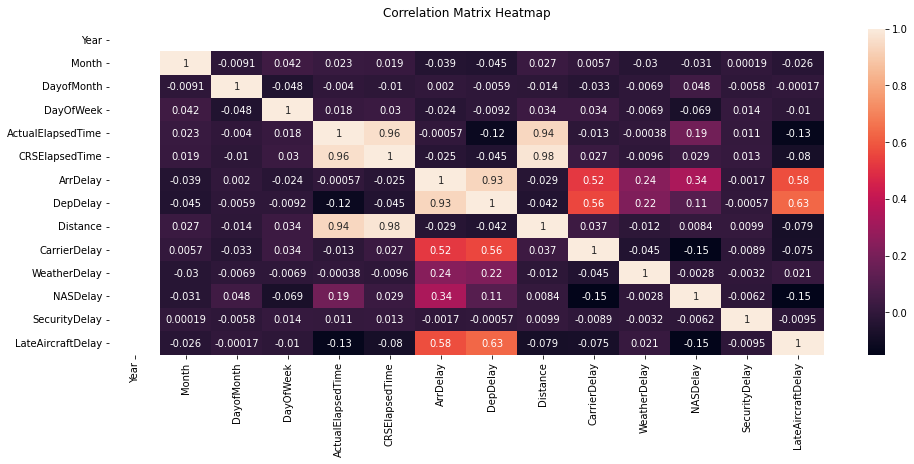

In [ ]:
#correlation matrix
import seaborn as sns
plt.figure(figsize=(16,6))
sns.heatmap(flights_usa_df.corr(), annot=True).set_title('Correlation Matrix Heatmap', fontdict={'fontsize':12}, pad=12)

Text(0, 0.5, 'Departure Delay in minutes')

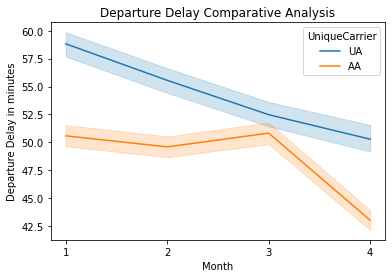

In [ ]:
import matplotlib.pyplot as plt
sns.lineplot(x = flights_usa_df["Month"], y = flights_usa_df["DepDelay"], hue = flights_usa_df["UniqueCarrier"])
plt.title("Departure Delay Comparative Analysis")
plt.xticks([1,2,3,4])
plt.xlabel("Month")
plt.ylabel("Departure Delay in minutes")

Text(0, 0.5, 'Arrival Delay in minutes')

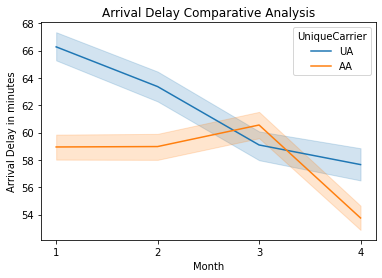

In [ ]:
import matplotlib.pyplot as plt
sns.lineplot(x = flights_usa_df["Month"], y = flights_usa_df["ArrDelay"], hue = flights_usa_df["UniqueCarrier"])
plt.title("Arrival Delay Comparative Analysis")
plt.xticks([1,2,3,4])
plt.xlabel("Month")
plt.ylabel("Arrival Delay in minutes")

Text(0, 0.5, 'Departure Delay in minutes')

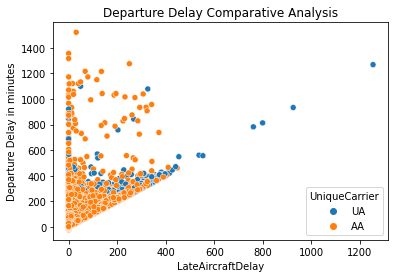

In [ ]:
import matplotlib.pyplot as plt
sns.scatterplot(x = flights_usa_df["LateAircraftDelay"], y = flights_usa_df["DepDelay"], hue = flights_usa_df["UniqueCarrier"])
plt.title("Departure Delay Comparative Analysis")
plt.ylabel("Departure Delay in minutes")

Text(0, 0.5, 'Arrival Delay in minutes')

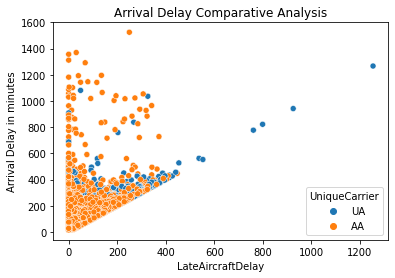

In [ ]:
import matplotlib.pyplot as plt
sns.scatterplot(x = flights_usa_df["LateAircraftDelay"], y = flights_usa_df["ArrDelay"], hue = flights_usa_df["UniqueCarrier"])
plt.title("Arrival Delay Comparative Analysis")
plt.ylabel("Arrival Delay in minutes")

#Code for Prediction


In [ ]:
enable_grid_search = False

#Linear Regression for ArrDelay:

In [ ]:
#splitting the 'medical_df' dataframe into train set and test set

flights_usa = flights_usa.withColumn('Cancelled', flights_usa.Cancelled.cast('int'))
flights_usa = flights_usa.withColumn('Diverted', flights_usa.Diverted.cast('int'))

train, test = flights_usa.randomSplit([0.8, 0.2], seed=10)

In [ ]:
#Linear Regression Model Pipeline:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors
from pyspark.ml import Pipeline

#define stage 1: feature engineering pipeline
#String indexer for UA AA uniqueCarrier

UniqueCarrier = StringIndexer(inputCol = "UniqueCarrier", outputCol = "UniqueCarrier_encoded")

#Create pipeline and pass all stages

fe_pipe = Pipeline(stages = [UniqueCarrier])

#define stage 2: create a vector of all the features required to train the linear regression model 
vec_assemble = VectorAssembler(inputCols = ['ActualElapsedTime', 'CRSElapsedTime', 'UniqueCarrier_encoded', 'Distance', 'Cancelled', 'Diverted',
                                'CarrierDelay','NASDelay','SecurityDelay','LateAircraftDelay'], 
                               outputCol = 'va_features')

#define stage 3: scaling the vectors
std_scalar = feature.StandardScaler(withMean = True, inputCol = 'va_features', outputCol = 'scaled_features') 

#define stage 4: re-creating a vector of all the scaled features required to train the linear regression model 
vec_assembler_2 = feature.VectorAssembler(inputCols = ['scaled_features'], outputCol = 'features')

#define stage 5: linear regression model                          
linear_reg = LinearRegression(featuresCol = 'features', labelCol = 'ArrDelay')

#setup the pipeline
lr_pipe = Pipeline(stages = [fe_pipe, vec_assemble, std_scalar, vec_assembler_2, linear_reg])

In [ ]:
#fitting the linear regression pipe to train data and testing it using test data
lr_model = lr_pipe.fit(train)
lr_flights_arr_df = lr_model.transform(test)

In [ ]:
#evaluating the model performance
from pyspark.ml.evaluation import RegressionEvaluator

r2_lr_eval = RegressionEvaluator(labelCol = 'ArrDelay', predictionCol = 'prediction', metricName = 'r2')
r2_lr_eval.evaluate(lr_model.transform(test))

0.9268067693263794

#Linear Regression for DepDelay

In [ ]:
#define stage 5: linear regression model          
vec_assemble = VectorAssembler(inputCols = ['ActualElapsedTime', 'CRSElapsedTime', 'UniqueCarrier_encoded', 'Distance', 'Cancelled', 'Diverted',
                                'CarrierDelay','NASDelay','SecurityDelay','LateAircraftDelay'], 
                               outputCol = 'va_features')

#define stage 3: scaling the vectors
std_scalar = feature.StandardScaler(withMean = True, inputCol = 'va_features', outputCol = 'scaled_features') 

#define stage 4: re-creating a vector of all the scaled features required to train the linear regression model 
vec_assembler_2 = feature.VectorAssembler(inputCols = ['scaled_features'], outputCol = 'features')

linear_reg_2 = LinearRegression(featuresCol = 'features', labelCol = 'DepDelay')

#setup the pipeline
lr_pipe_2 = Pipeline(stages = [fe_pipe, vec_assemble, std_scalar, vec_assembler_2, linear_reg_2])

In [ ]:
#fitting the linear regression pipe to train data and testing it using test data
lr_model_2 = lr_pipe_2.fit(train)
lr_flights_dep_df = lr_model_2.transform(test)

In [ ]:
#evaluating the model performance
r2_lr_eval_2 = RegressionEvaluator(labelCol = 'DepDelay', predictionCol = 'prediction', metricName = 'r2')
r2_lr_eval_2.evaluate(lr_model_2.transform(test))

0.9314517846211676

In [ ]:
coefficient_values_arr = lr_model.stages[-1].coefficients
coefficient_values_dep = lr_model_2.stages[-1].coefficients

In [ ]:
important_features_arr = pd.DataFrame({'Features': ['ActualElapsedTime', 'CRSElapsedTime', 'UniqueCarrier_encoded', 'Distance', 'Cancelled', 'Diverted',
                                'CarrierDelay','NASDelay','SecurityDelay','LateAircraftDelay'], 
                                'Value': coefficient_values_arr}).sort_values(by=['Value'], ascending=False)

In [ ]:
important_features_arr

,Features,Value
9,LateAircraftDelay,41.425562
6,CarrierDelay,38.822466
7,NASDelay,31.082308
0,ActualElapsedTime,3.218610
8,SecurityDelay,0.820379
4,Cancelled,0.000000
5,Diverted,0.000000
2,UniqueCarrier_encoded,-0.334275
3,Distance,-0.777301
1,CRSElapsedTime,-2.429261


In [ ]:
important_features_dep = pd.DataFrame({'Features': ['ActualElapsedTime', 'CRSElapsedTime', 'UniqueCarrier_encoded', 'Distance', 'Cancelled', 'Diverted',
                                'CarrierDelay','NASDelay','SecurityDelay','LateAircraftDelay'], 
                                'Value': coefficient_values_dep}).sort_values(by=['Value'], ascending=False)

In [ ]:
important_features_dep

,Features,Value
1,CRSElapsedTime,75.485779
9,LateAircraftDelay,41.425562
6,CarrierDelay,38.822466
7,NASDelay,31.082309
8,SecurityDelay,0.820378
4,Cancelled,0.000000
5,Diverted,0.000000
2,UniqueCarrier_encoded,-0.334276
3,Distance,-0.777301
0,ActualElapsedTime,-78.925339


#Random Forest for ArrDelay

In [ ]:
#Random Forest Regressor Model Pipeline:
from pyspark.ml.regression import RandomForestRegressor

#define stage 5: random forest regression model                          
rf = RandomForestRegressor(featuresCol = 'features', labelCol = 'ArrDelay')
rf_pipe = Pipeline(stages = [fe_pipe, vec_assemble, std_scalar, vec_assembler_2, rf])

In [ ]:
#fitting the random forest regression pipe to train data and testing it using test data
rf_model = rf_pipe.fit(train)
rf_flights_arr_df = rf_model.transform(test)

In [ ]:
#evaluating the model performance
r2_rf_eval = RegressionEvaluator(labelCol = 'ArrDelay', predictionCol = 'prediction', metricName = 'r2')
r2_rf_eval.evaluate(rf_model.transform(test))

0.6680571142851117

###Random Forest for DepDelay

In [ ]:
#Random Forest Regressor Model Pipeline:
from pyspark.ml.regression import RandomForestRegressor

#define stage 5: random forest regression model                          
rf_2 = RandomForestRegressor(featuresCol = 'features', labelCol = 'DepDelay')
rf_pipe_2 = Pipeline(stages = [fe_pipe, vec_assemble, std_scalar, vec_assembler_2, rf_2])

In [ ]:
#fitting the random forest regression pipe to train data and testing it using test data
rf_model_2 = rf_pipe_2.fit(train)
rf_flights_dep_df = rf_model_2.transform(test)

In [ ]:
#evaluating the model performance
r2_rf_eval_2 = RegressionEvaluator(labelCol = 'DepDelay', predictionCol = 'prediction', metricName = 'r2')
r2_rf_eval_2.evaluate(rf_model.transform(test))

0.588933442193029

#Random Forest: HyperParameter Tuning for ArrDelay

In [ ]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder

if enable_grid_search:
  UniqueCarrier = StringIndexer(inputCol = "UniqueCarrier", outputCol = "UniqueCarrier_encoded")
  fe_pipe = Pipeline(stages = [UniqueCarrier])
  vec_assemble = VectorAssembler(inputCols = ['ActualElapsedTime', 'CRSElapsedTime', 'UniqueCarrier_encoded', 'Distance', 'Cancelled', 'Diverted',
                                              'CarrierDelay', 'WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay'], 
                                 outputCol = 'va_features')
  std_scalar = feature.StandardScaler(withMean = True, inputCol = 'va_features', outputCol = 'scaled_features') 
  vec_assembler_2 = feature.VectorAssembler(inputCols = ['scaled_features'], outputCol = 'features')
  rf = RandomForestRegressor(featuresCol = 'features', labelCol = 'ArrDelay')
  rf_pipe = Pipeline(stages = [fe_pipe, vec_assemble, std_scalar, vec_assembler_2, rf])

  grid = ParamGridBuilder().addGrid(rf.numTrees, [3,5,8]).addGrid(rf.maxDepth, [2,5,10]).addGrid(rf.maxBins, [2,5,10]).build()
  mse = {}
  all_models = []
  for j in range(len(grid)):
      print("Training model {}".format(j+1))
      model = rf_pipe.fit(train, grid[j])
      all_models.append(model)
  i = 0
  for model in all_models:
     predictions = model.transform(test)
     evaluator = RegressionEvaluator(labelCol = "ArrDelay", predictionCol = "prediction", metricName = 'mse')
     mse[i] = evaluator.evaluate(predictions)
     i+=1
  minmse = min(mse.keys(), key = (lambda k: mse[k]))
  print("Best Model",grid[minmse])
  best_model = all_models[minmse]
  best_model.transform(test)
  evaluator = RegressionEvaluator(labelCol = "ArrDelay", predictionCol = "prediction", metricName = 'mse')
  print("Best Model Test MSE:",evaluator.evaluate(predictions))
  pass

In [ ]:
#tuned parameters hardcoded
trees = 8
depth = 10
bins = 10

#define stage 5: random forest regression model                          
rf = RandomForestRegressor(featuresCol = 'features', labelCol = 'ArrDelay').setNumTrees(trees).setMaxDepth(depth).setMaxBins(bins)
best_rf_pipe = Pipeline(stages = [fe_pipe, vec_assemble, std_scalar, vec_assembler_2, rf]).fit(train)

In [ ]:
predictions = best_rf_pipe.transform(train)
evaluator = RegressionEvaluator(labelCol = "ArrDelay", predictionCol = "prediction", metricName = 'r2')
rf_train_r2 = evaluator.evaluate(predictions)
print("Best Model Training R2:", rf_train_r2)

predictions = best_rf_pipe.transform(test)
evaluator = RegressionEvaluator(labelCol = "ArrDelay", predictionCol = "prediction", metricName = 'r2')
rf_test_r2 = evaluator.evaluate(predictions)
print("Best Model Testing R2:",rf_test_r2)

Best Model Training R2: 0.6136021164182106
Best Model Testing R2: 0.546695576289089


###Random Forest Hyper param tuning for DepDelay

In [ ]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder

if enable_grid_search:
  UniqueCarrier = StringIndexer(inputCol = "UniqueCarrier", outputCol = "UniqueCarrier_encoded")
  fe_pipe = Pipeline(stages = [UniqueCarrier])
  vec_assemble = VectorAssembler(inputCols = ['ActualElapsedTime', 'CRSElapsedTime', 'UniqueCarrier_encoded', 'Distance', 'Cancelled', 'Diverted',
                                              'CarrierDelay', 'WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay'], 
                                 outputCol = 'va_features')
  std_scalar = feature.StandardScaler(withMean = True, inputCol = 'va_features', outputCol = 'scaled_features') 
  vec_assembler_2 = feature.VectorAssembler(inputCols = ['scaled_features'], outputCol = 'features')
  rf = RandomForestRegressor(featuresCol = 'features', labelCol = 'DepDelay')
  rf_pipe = Pipeline(stages = [fe_pipe, vec_assemble, std_scalar, vec_assembler_2, rf])

  grid = ParamGridBuilder().addGrid(rf.numTrees, [3,5,8]).addGrid(rf.maxDepth, [2,5,10]).addGrid(rf.maxBins, [2,5,10]).build()
  mse = {}
  all_models = []
  for j in range(len(grid)):
      print("Training model {}".format(j+1))
      model = rf_pipe.fit(train, grid[j])
      all_models.append(model)
  i = 0
  for model in all_models:
     predictions = model.transform(test)
     evaluator = RegressionEvaluator(labelCol = "DepDelay", predictionCol = "prediction", metricName = 'mse')
     mse[i] = evaluator.evaluate(predictions)
     i+=1
  minmse = min(mse.keys(), key = (lambda k: mse[k]))
  print("Best Model",grid[minmse])
  best_model = all_models[minmse]
  best_model.transform(test)
  evaluator = RegressionEvaluator(labelCol = "DepDelay", predictionCol = "prediction", metricName = 'mse')
  print("Best Model Test MSE:",evaluator.evaluate(predictions))
  pass

In [ ]:
#tuned parameters hardcoded
trees = 5
depth = 10
bins = 10

#define stage 5: random forest regression model                          
rf = RandomForestRegressor(featuresCol = 'features', labelCol = 'DepDelay').setNumTrees(trees).setMaxDepth(depth).setMaxBins(bins)
best_rf_pipe = Pipeline(stages = [fe_pipe, vec_assemble, std_scalar, vec_assembler_2, rf]).fit(train)

In [ ]:
predictions = best_rf_pipe.transform(train)
evaluator = RegressionEvaluator(labelCol = "DepDelay", predictionCol = "prediction", metricName = 'r2')
rf_train_r2 = evaluator.evaluate(predictions)
print("Best Model Training R2:", rf_train_r2)

predictions = best_rf_pipe.transform(test)
evaluator = RegressionEvaluator(labelCol = "DepDelay", predictionCol = "prediction", metricName = 'r2')
rf_test_r2 = evaluator.evaluate(predictions)
print("Best Model Testing R2:",rf_test_r2)

Best Model Training R2: 0.6163796490826046
Best Model Testing R2: 0.5654977790160984


#Gradient Boost Regressor for ArrDelay

In [ ]:
#Gradient Booster Regressor Model Pipeline:
from pyspark.ml.regression import GBTRegressor

#define stage 5: gradient booster regression model                          
gbt = GBTRegressor(featuresCol = 'features', labelCol = 'ArrDelay')
gbt_pipe = Pipeline(stages = [fe_pipe, vec_assemble, std_scalar, vec_assembler_2, gbt])

In [ ]:
#fitting the random forest regression pipe to train data and testing it using test data
gbt_model = gbt_pipe.fit(train)
gbt_flights_arr_df = gbt_model.transform(test)

In [ ]:
#evaluating the model performance
r2_gbt_eval = RegressionEvaluator(labelCol = 'ArrDelay', predictionCol = 'prediction', metricName = 'r2')
r2_gbt_eval.evaluate(gbt_model.transform(test))

0.7353249644248363

#Gradient Booster Regressor for DepDelay

In [ ]:
#Gradient Booster Regressor Model Pipeline:
from pyspark.ml.regression import GBTRegressor

#define stage 5: gradient booster regression model                          
gbt_2 = GBTRegressor(featuresCol = 'features', labelCol = 'DepDelay')
gbt_pipe_2 = Pipeline(stages = [fe_pipe, vec_assemble, std_scalar, vec_assembler_2, gbt_2])

In [ ]:
#fitting the random forest regression pipe to train data and testing it using test data
gbt_model_2 = gbt_pipe_2.fit(train)
gbt_flights_dep_df = gbt_model_2.transform(test)

In [ ]:
#evaluating the model performance
r2_gbt_eval_2 = RegressionEvaluator(labelCol = 'DepDelay', predictionCol = 'prediction', metricName = 'r2')
r2_gbt_eval_2.evaluate(gbt_model_2.transform(test))

0.7429113477348703

#Gradient Booster Regression: HyperParameter Tuning for ArrDelay

In [ ]:
from pyspark.ml.regression import GBTRegressor

if enable_grid_search:
  UniqueCarrier = StringIndexer(inputCol = "UniqueCarrier", outputCol = "UniqueCarrier_encoded")
  fe_pipe = Pipeline(stages = [UniqueCarrier])
  vec_assemble = VectorAssembler(inputCols = ['ActualElapsedTime', 'CRSElapsedTime', 'UniqueCarrier_encoded', 'Distance', 'Cancelled', 'Diverted',
                                              'CarrierDelay', 'WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay'], 
                                 outputCol = 'va_features')
  std_scalar = feature.StandardScaler(withMean = True, inputCol = 'va_features', outputCol = 'scaled_features') 
  vec_assembler_2 = feature.VectorAssembler(inputCols = ['scaled_features'], outputCol = 'features')
  gbt = GBTRegressor(featuresCol = 'features', labelCol = 'ArrDelay')
  gbt_pipe = Pipeline(stages = [fe_pipe, vec_assemble, std_scalar, vec_assembler_2, gbt])
  grid = ParamGridBuilder().addGrid(gbt.maxDepth, [2, 5, 10]).addGrid(gbt.maxBins, [10, 20, 25]).build()
  mse = {}
  all_models = []
  for j in range(len(grid)):
      print("Training model {}".format(j+1))
      model = gbt_pipe.fit(train, grid[j])
      all_models.append(model)
  i=0
  for model in all_models:
     predictions = model.transform(test)
     evaluator = RegressionEvaluator(labelCol = "ArrDelay", predictionCol = "prediction", metricName = 'mse')
     mse[i] = evaluator.evaluate(predictions)
     i+=1
  minmse = min(mse.keys(), key=(lambda k: mse[k]))
  print("Best Model",grid[minmse])
  best_model = all_models[minmse]
  best_model.transform(test)
  evaluator = RegressionEvaluator(labelCol = "ArrDelay", predictionCol = "prediction", metricName = 'mse')
  print("Best Model Test MSE:",evaluator.evaluate(predictions))
  pass

In [ ]:
#tuned parameters hardcoded
depth = 5
bins = 25

gbt = GBTRegressor().setLabelCol('ArrDelay').setFeaturesCol('features').setMaxDepth(depth).setMaxBins(bins)
best_gbt_pipe = Pipeline(stages = [fe_pipe, vec_assemble, std_scalar, vec_assembler_2, gbt]).fit(train)

In [ ]:
predictions = best_gbt_pipe.transform(train)
evaluator = RegressionEvaluator(labelCol = "ArrDelay", predictionCol = "prediction", metricName = 'r2')
gbt_train_r2 = evaluator.evaluate(predictions)
print("Best Model Training R2:", gbt_train_r2)

predictions = best_rf_pipe.transform(test)
evaluator = RegressionEvaluator(labelCol = "ArrDelay", predictionCol = "prediction", metricName = 'r2')
gbt_test_r2 = evaluator.evaluate(predictions)
print("Best Model Test R2:",gbt_test_r2)

Best Model Training R2: 0.7525984094216058
Best Model Test R2: 0.430883548306745


#Gradient Booster Regression: HyperParameter Tuning for DepDelay

In [ ]:
from pyspark.ml.regression import GBTRegressor

if enable_grid_search:
  UniqueCarrier = StringIndexer(inputCol = "UniqueCarrier", outputCol = "UniqueCarrier_encoded")
  fe_pipe = Pipeline(stages = [UniqueCarrier])
  vec_assemble = VectorAssembler(inputCols = ['ActualElapsedTime', 'CRSElapsedTime', 'UniqueCarrier_encoded', 'Distance', 'Cancelled', 'Diverted',
                                              'CarrierDelay', 'WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay'], 
                                 outputCol = 'va_features')
  std_scalar = feature.StandardScaler(withMean = True, inputCol = 'va_features', outputCol = 'scaled_features') 
  vec_assembler_2 = feature.VectorAssembler(inputCols = ['scaled_features'], outputCol = 'features')
  gbt = GBTRegressor(featuresCol = 'features', labelCol = 'DepDelay')
  gbt_pipe = Pipeline(stages = [fe_pipe, vec_assemble, std_scalar, vec_assembler_2, gbt])
  grid = ParamGridBuilder().addGrid(gbt.maxDepth, [2, 5, 10]).addGrid(gbt.maxBins, [10, 20, 25]).build()
  mse = {}
  all_models = []
  for j in range(len(grid)):
      print("Training model {}".format(j+1))
      model = gbt_pipe.fit(train, grid[j])
      all_models.append(model)
  i=0
  for model in all_models:
     predictions = model.transform(test)
     evaluator = RegressionEvaluator(labelCol = "DepDelay", predictionCol = "prediction", metricName = 'mse')
     mse[i] = evaluator.evaluate(predictions)
     i+=1
  minmse = min(mse.keys(), key=(lambda k: mse[k]))
  print("Best Model",grid[minmse])
  best_model = all_models[minmse]
  best_model.transform(test)
  evaluator = RegressionEvaluator(labelCol = "DepDelay", predictionCol = "prediction", metricName = 'mse')
  print("Best Model Test MSE:",evaluator.evaluate(predictions))
  pass

In [ ]:
#tuned parameters hardcoded
depth = 5
bins = 25

gbt_2 = GBTRegressor().setLabelCol('DepDelay').setFeaturesCol('features').setMaxDepth(depth).setMaxBins(bins)
best_gbt_pipe_2 = Pipeline(stages = [fe_pipe, vec_assemble, std_scalar, vec_assembler_2, gbt_2]).fit(train)

In [ ]:
predictions = best_gbt_pipe.transform(train)
evaluator = RegressionEvaluator(labelCol = "DepDelay", predictionCol = "prediction", metricName = 'r2')
gbt_train_r2 = evaluator.evaluate(predictions)
print("Best Model Training R2:", gbt_train_r2)

predictions = best_rf_pipe.transform(test)
evaluator = RegressionEvaluator(labelCol = "DepDelay", predictionCol = "prediction", metricName = 'r2')
gbt_test_r2 = evaluator.evaluate(predictions)
print("Best Model Test R2:",gbt_test_r2)

Best Model Training R2: 0.6305647355997702
Best Model Test R2: 0.5654977790160984
